## Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

## Camera calibration using chessboard images

In [2]:
def calibrate():
    """
    This function is used to calibrate camera from images of chessboard 
    captured from a camera for which camera matrix and distortion 
    coefficients are to be calculated 
    """
    # Create object points (0 0 0) ... (8 5 0)
    objp = np.zeros((9*6, 3), np.float32) 
    
    # assign grid points to x and y keeping z as zero
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    for indx, fname in enumerate(images):
        
        img = cv2.imread(fname)
        
        # Converting to grayclae - findChessboardCorners expects graysclae image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find inner corners of chess baord
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Save camera matrix and distortion coefficient to pickle file
    
    calibration_param = {}
    calibration_param['mtx'] = mtx
    calibration_param['dist'] = dist
    pickle.dump( calibration_param, open('camera_cal/calibration_pickle.pickle', 'wb') )

In [3]:
calibrate()

## Undistorting image using camera matrix and distortion coefficient

In [4]:
def undistort_img(img, cal_dir = 'camera_cal/calibration_pickle.pickle'):
    """
    'img' is the input image with distortion
    'cal_dir' = path to saved camera matrix and distortion coefficients
    given thses two inputs thia function undistorts the image
    """
    
    # Read saved file
    with open(cal_dir, mode = 'rb') as f:
        file = pickle.load(f)
        
    mtx = file['mtx'] # camera matrix
    dist = file['dist'] # Distortion coefficients
    
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted_img

### Testing undistorion on chessboard and sample road image

Text(0.5, 1.0, 'Undistorted image')

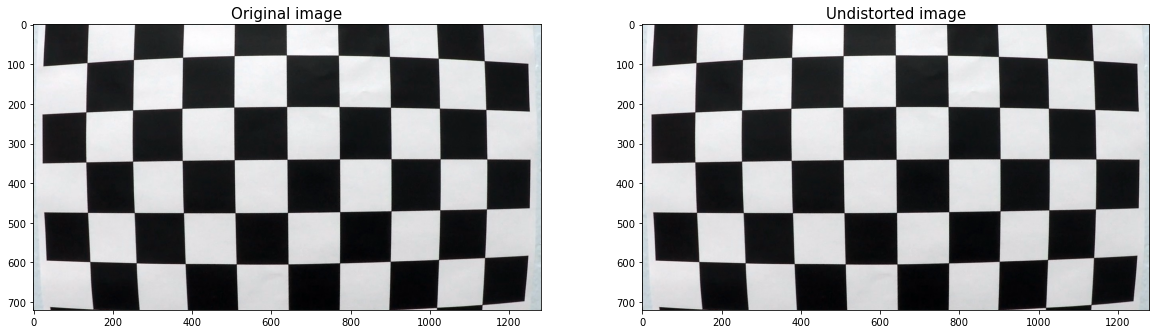

In [5]:
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted_img = img

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(img)
ax1.set_title('Original image', fontsize = 15)

ax2.imshow(undistorted_img)
ax2.set_title('Undistorted image', fontsize = 15)

Text(0.5, 1.0, 'Undistorted image')

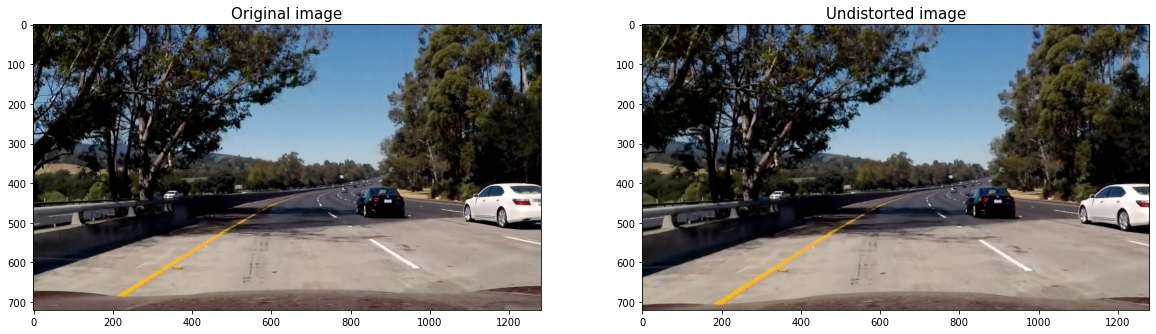

In [6]:
img = cv2.imread('test_images/test5.jpg')

#cv2 read in BGR formate where as matplotlib as RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(img)
ax1.set_title('Original image', fontsize = 15)

ax2.imshow(undistorted_img)
ax2.set_title('Undistorted image', fontsize = 15)

## Thresholding - Color thresholding and Gradient thresholding

In [7]:
def img_threshold(img, s_thresh=(101, 255), sx_thresh=(20, 255)): 
    
    undistorted_img = img
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    s_channel = hls[:, :, 1] 
    v_channel = hls[:, :, 2]
    

    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary, img

## Perspective and Inverse perspective transform

In [8]:
def perspective_transform(img):
    
    src = np.float32([[428,686],[762,686],[31,1168],[1190,1168]])
    dst = np.float32([ [0, 0], [1201, 0], [0, 1600], [1201, 1600]])
    
    img_size = (img.shape[1],img.shape[0])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def inv_perspective_transform(img):
    
    dst = np.float32([[428,686],[762,686],[31,1168],[1190,1168]])
    src = np.float32([ [0, 0], [1201, 0], [0, 1600], [1201, 1600]])
    
    img_size = (img.shape[1],img.shape[0])

    # Given src and dst points, calculate the inverse-perspective transform matrix 
    #(which is just perspective transform with src and dst interchanged)
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

Text(0.5, 1.0, 'Warped thresholded image')

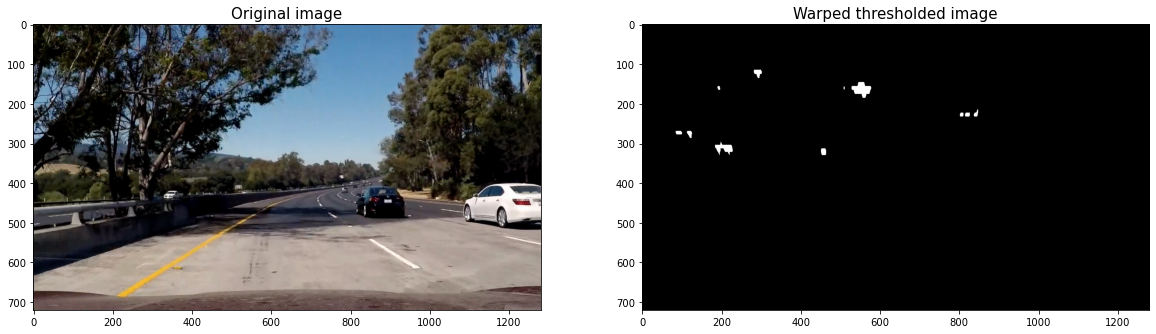

In [9]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
threshold_img, undistorted_img = img_threshold(img)
warped_img = perspective_transform(threshold_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(img)
ax1.set_title('Original image', fontsize = 15)

ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped thresholded image', fontsize = 15)

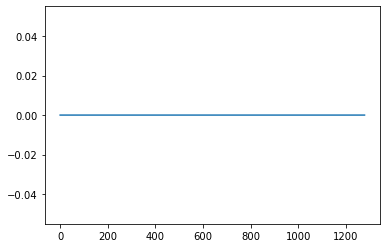

In [10]:
plt.plot(get_hist(warped_img))

# Helper functions

In [11]:
def find_lane_pixels(binary_warped):
    """
    only for the first frame of the video this function is run.
    
    input - 'binary_warped' perspective transformed thresholded image
    output - x and y coordinates of the lane pixels
    
    step 1: Get the histogram of warped input image
    step 2: find peaks in the histogram that serves as midpoint for our first window
    step 3: choose hyperparameter for windows
    step 4: Get x, y coordinates of all the non zero pixels in the image
    step 5: for each window in number of windows get indices of all non zero pixels falling in that window
    step 6: Get the x, y coordinates based off of these indices
    """
    # Take a histogram of the bottom half of the image
    histogram = get_hist(binary_warped)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 200

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # the four boundaries of the window ###
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if the no of pixels in the current window > minpix then update window center
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [12]:
def fit_poly(leftx, lefty, rightx, righty):
    """
    Given x and y coordinates of lane pixels fir 2nd order polynomial through them
    
    here the function is of y and not x that is
    
    x = f(y) = Ay**2 + By + C
    
    returns coefficients A, B, C for each lane (left lane and right lane)
    """
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

In [13]:
def search_around_poly(binary_warped, left_fit, right_fit):
    """
    This function is extension to function find_lane_pixels().
    
    From second frame onwards of the video this function will be run.
    
    the idea is that we dont have to re-run window search for each and every frame.
    
    once we know where the lanes are, we can make educated guess about the position of lanes in the consecutive frame,
    
    because lane lines are continuous and dont change much from frame to frame(unless a very abruspt sharp turn).
    
    This function takes in the fitted polynomial from previous frame defines a margin and looks for non zero pixels 
    in that range only. it greatly increases the speed of the detection.
    """
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # we have left fitted polynomial (left_fit) and right fitted polynomial (right_fit) from previous frame,
    # using these polynomial and y coordinates of non zero pixels from warped image, 
    # we calculate corrsponding x coordinate and check if lies within margin, if it does then
    # then we count that pixel as being one from the lane lines.
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin))).nonzero()[0]
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin))).nonzero()[0]
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx = fit_poly(leftx, lefty, rightx, righty)

    return leftx, lefty, rightx, righty

In [14]:
def measure_curvature_real(left_fit_cr, right_fit_cr, img_shape):
    '''
    Calculates the curvature of polynomial functions in meters.
    and returns the position of vehical relative to the center of the lane
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img_shape[0]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # It was meentioned in one the course note that camera was mounted in the middle of the car,
    # so the postiion of the car is middle of the image, the we calculate the middle of lane using
    # two fitted polynomials
    car_pos = img_shape[1]/2
    left_lane_bottom_x = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    right_lane_bottom_x = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = ((right_lane_bottom_x - left_lane_bottom_x) / 2) + left_lane_bottom_x
    car_center_offset = np.abs(car_pos - lane_center_position) * xm_per_pix
    
    return (left_curverad, right_curverad, car_center_offset)

In [15]:
def draw_lane(warped_img, undistorted_img, left_fit, right_fit):
    """
    Given warped image and original undistorted original image this function 
    draws final lane on the undistorted image
    """
    # Generate x and y values for plotting
    ploty = np.linspace(0, undistorted_img.shape[0]-1, undistorted_img.shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = inv_perspective_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    return result

# Final pipeline

For the first frame `find_lane_pixels()` function is called then from second frame onwards `search_around_poly()` is called.

In [16]:
first_run = True
gleft_fit = gright_fit = None

def Pipeline(img):
    global first_run, gleft_fit, gright_fit
    
    
    threshold_img, undistorted_img = img_threshold(img)
    
    warped_img = perspective_transform(threshold_img)
    
    if first_run:
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)
        left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
        gleft_fit = left_fit
        gright_fit = right_fit
        first_run = False
    else:
        leftx, lefty, rightx, righty = search_around_poly(warped_img, gleft_fit, gright_fit)
        left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
        gleft_fit = left_fit
        gright_fit = right_fit
    
    #print(left_fitx, right_fitx)
    measures = measure_curvature_real(left_fit, right_fit, img_shape = img.shape)
    print(img.shape)
    
    final_img = draw_lane(warped_img, undistorted_img, left_fit, right_fit)
    
    # writing lane curvature and vehical offset on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize = 1
    cv2.putText(final_img, 'Lane Curvature: {:.0f} m'.format(np.mean([measures[0],measures[1]])), 
                (500, 620), font, fontSize, fontColor, 2)
    cv2.putText(final_img, 'Vehicle offset: {:.4f} m'.format(measures[2]), (500, 650), font, fontSize, fontColor, 2)
    
    return final_img

# Testing Images

/var/folders/2p/8rq7kl1j27nftt5zfzsg8tyc0000gn/T/ipykernel_23199/824385772.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]//2)
/var/folders/2p/8rq7kl1j27nftt5zfzsg8tyc0000gn/T/ipykernel_23199/824385772.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your 

(1600, 1201, 3)
(1600, 1201, 3)


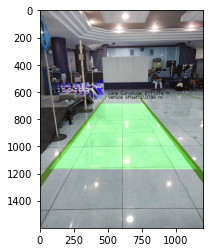

In [17]:
gambar = cv2.imread("lane_detection_hijau.jpeg")
gambar1 = cv2.imread("./test_images/test1.jpg")
plt.imshow(Pipeline(gambar))
cv2.imshow('marked',Pipeline(gambar))